[*********************100%***********************]  1 of 1 completed


🔍 Regime Summary (Sorted by Volatility):
        Mean_Return  Volatility  Days_in_Regime  Annualised_Volatility (%)
Regime                                                                    
1          0.001623    0.004197             835                   6.662142
0         -0.001988    0.015911             421                  25.258543


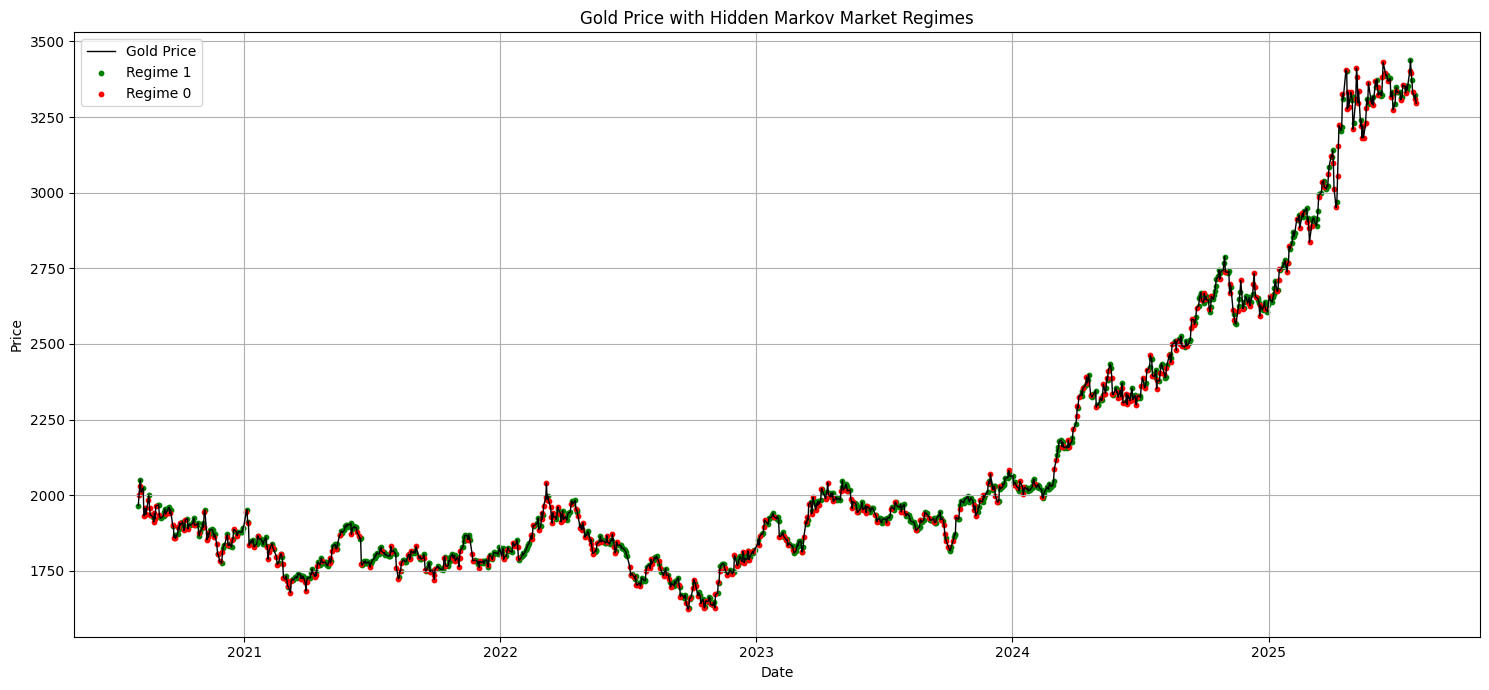

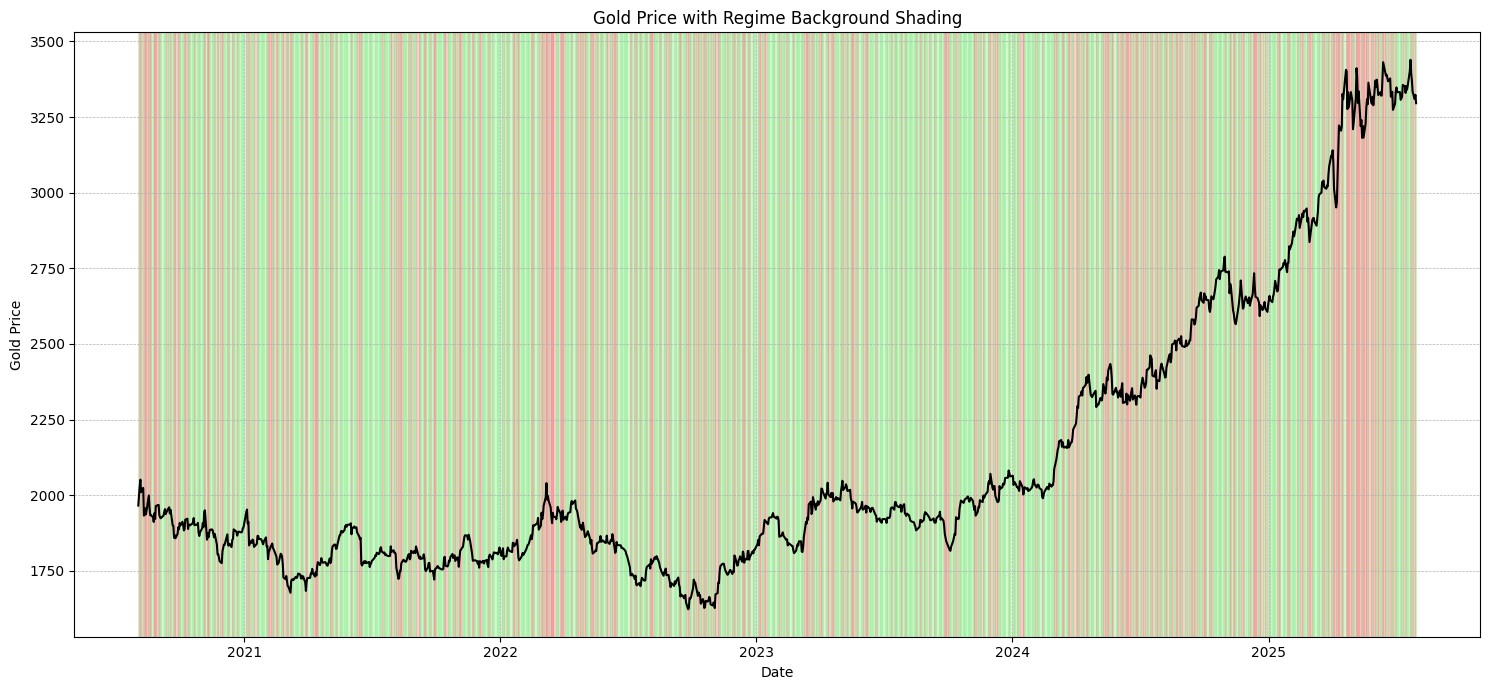

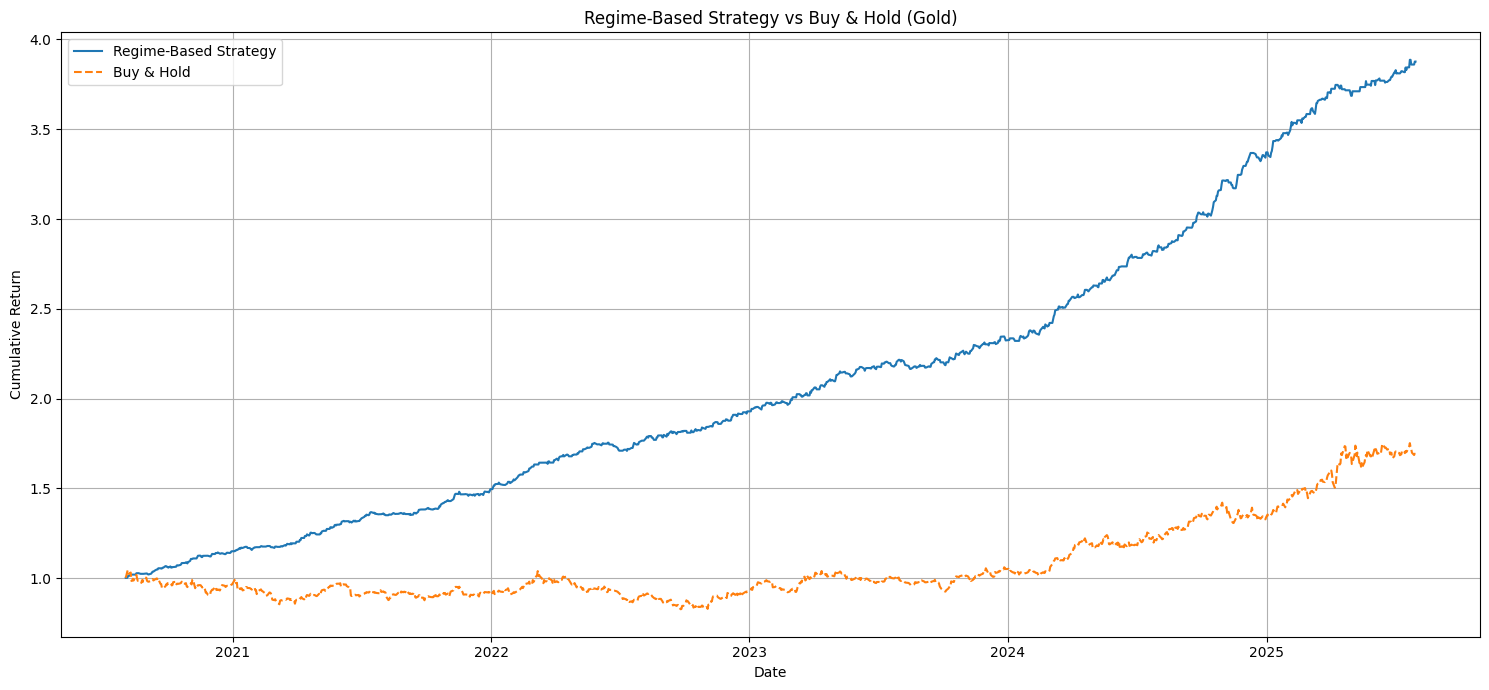


📈 Top 10 Assets by HMM Strategy Outperformance (%):
   Ticker  Strategy_ROI (%)  BuyHold_ROI (%)  Outperformance (%)
4    NG=F            481.37            69.26              412.11
2    CL=F            468.53            73.83              394.71
3    BZ=F            260.73            69.15              191.59
11   ^NDX            238.55           114.06              124.49
5    ZC=F            125.22            23.97              101.24
30    XLK            221.07           149.66               71.41
6    ZS=F             64.95             7.83               57.12
29    XLF            182.76           140.08               42.68
10  ^GSPC            135.57            94.52               41.05
12   ^DJI            103.69            68.23               35.46


In [ ]:

# HMM Regime Detection and Trading Strategy


!pip -q install yfinance hmmlearn scikit-learn --upgrade

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler

# Configuration
START_DATE = "2020-07-31"
END_DATE = "2025-07-31"
GOLD_TICKER = "GC=F"

# List of tickers for multi-asset analysis
TICKERS = [
    'GC=F', 'SI=F', 'CL=F', 'BZ=F', 'NG=F', 'ZC=F', 'ZS=F', 'ZW=F', 'KC=F', 'CT=F',
    '^GSPC', '^NDX', '^DJI', '^RUT', '^FTSE', '^N225', '^HSI', '^STOXX50E', '^AXJO',
    'UUP', 'FXE', 'FXY', 'FXB', 'FXA', 'TLT', 'IEF', 'SHY', 'TIP',
    'XLE', 'XLF', 'XLK', 'XLV', 'XLI', 'XLP', 'AAPL', 'MSFT', 'TSLA', 'GOOGL', 'AMZN'
]

#Helper Function: HMM Fitting
def fit_hmm_and_predict_states(returns_series, n_components=2, n_iter=3000, random_state=42, tol=1e-2):
    """
    Fits a Gaussian Hidden Markov Model to a series of log returns and predicts the hidden states.

    Args:
        returns_series (pd.Series): A pandas Series of log returns indexed by date.
        n_components (int): The number of hidden states (regimes).
        n_iter (int): The number of iterations for the HMM fitting algorithm.
        random_state (int): Seed for the random number generator.
        tol (float): The convergence tolerance.

    Returns:
        np.ndarray: The predicted sequence of hidden states.
    """
    scaler = StandardScaler()
    scaled_returns = scaler.fit_transform(returns_series.values.reshape(-1, 1))

    hmm_model = GaussianHMM(
        n_components=n_components,
        covariance_type="full",
        n_iter=n_iter,
        random_state=random_state,
        tol=tol
    )
    hmm_model.fit(scaled_returns)
    predicted_states = hmm_model.predict(scaled_returns)
    return predicted_states

# Single Asset Analysis: Gold

gold_data = yf.download(GOLD_TICKER, start=START_DATE, end=END_DATE)
gold_data = gold_data[['Close']].dropna()
gold_data['Log_Returns'] = np.log(gold_data['Close'] / gold_data['Close'].shift(1))
gold_data = gold_data.dropna()

# Fit HMM and assign regimes
gold_data['Regime'] = fit_hmm_and_predict_states(gold_data['Log_Returns'])

# Analyze regime characteristics
regime_stats = (
    gold_data.groupby('Regime')['Log_Returns']
    .agg(['mean', 'std', 'count'])
    .rename(columns={'mean': 'Mean_Return', 'std': 'Volatility', 'count': 'Days_in_Regime'})
)
regime_stats['Annualised_Volatility (%)'] = regime_stats['Volatility'] * np.sqrt(252) * 100
regime_stats = regime_stats.sort_values('Volatility')

print("🔍 Regime Summary (Sorted by Volatility):")
print(regime_stats)

# Plotting for Gold

plt.figure(figsize=(15, 7))
plt.plot(gold_data.index, gold_data['Close'], label='Gold Price', color='black', linewidth=1)
for regime, color in zip(regime_stats.index, ['green', 'red']):
    regime_data = gold_data[gold_data['Regime'] == regime]
    plt.scatter(regime_data.index, regime_data['Close'], color=color, label=f'Regime {regime}', s=10)
plt.title('Gold Price with Hidden Markov Market Regimes')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Price with regimes as background shading
plt.figure(figsize=(15, 7))
plt.plot(gold_data.index, gold_data['Close'], label='Gold Price', color='black', linewidth=1.5)
for i in range(len(gold_data) - 1):
    color = 'lightgreen' if gold_data['Regime'].iloc[i] == regime_stats.index[0] else 'lightcoral'
    plt.axvspan(gold_data.index[i], gold_data.index[i+1], color=color, alpha=0.3)
plt.title("Gold Price with Regime Background Shading")
plt.xlabel("Date")
plt.ylabel("Gold Price")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


# GolD Backtest

# Strategy: Invest only in the lowest-volatility regime
low_vol_regime = regime_stats.index[0]
gold_data['Strategy_Returns'] = np.where(gold_data['Regime'] == low_vol_regime, gold_data['Log_Returns'], 0.0)
gold_data['BuyHold_Returns'] = gold_data['Log_Returns']

# Calculate cumulative returns
gold_data['Strategy_Cumulative'] = np.exp(gold_data['Strategy_Returns'].cumsum())
gold_data['BuyHold_Cumulative'] = np.exp(gold_data['BuyHold_Returns'].cumsum())

plt.figure(figsize=(15, 7))
plt.plot(gold_data.index, gold_data['Strategy_Cumulative'], label='Regime-Based Strategy')
plt.plot(gold_data.index, gold_data['BuyHold_Cumulative'], label='Buy & Hold', linestyle='--')
plt.title('Regime-Based Strategy vs Buy & Hold (Gold)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#Multi-asset Strategy Evaluation
def evaluate_hmm_strategy(ticker):
    """
    Evaluates the HMM regime-based strategy for a given ticker.
    """
    try:
        asset_data = yf.download(ticker, start=START_DATE, end=END_DATE, progress=False)
        asset_data = asset_data[['Close']].dropna()
        asset_data['Log_Returns'] = np.log(asset_data['Close'] / asset_data['Close'].shift(1))
        asset_data = asset_data.dropna()

        if len(asset_data) < 50:
            return None

        asset_data['Regime'] = fit_hmm_and_predict_states(asset_data['Log_Returns'], n_iter=1000)


        regime_volatility = asset_data.groupby('Regime')['Log_Returns'].std()
        low_vol_regime = regime_volatility.idxmin()


        asset_data['Position'] = (asset_data['Regime'] == low_vol_regime).shift(1).fillna(0).astype(int)
        asset_data['Strategy_Returns'] = asset_data['Position'] * asset_data['Log_Returns']
        asset_data['BuyHold_Returns'] = asset_data['Log_Returns']

        strategy_cumulative_return = np.exp(asset_data['Strategy_Returns'].cumsum())[-1]
        buy_hold_cumulative_return = np.exp(asset_data['BuyHold_Returns'].cumsum())[-1]

        return {
            'Ticker': ticker,
            'Strategy_ROI (%)': (strategy_cumulative_return - 1) * 100,
            'BuyHold_ROI (%)': (buy_hold_cumulative_return - 1) * 100,
            'Outperformance (%)': ((strategy_cumulative_return - 1) - (buy_hold_cumulative_return - 1)) * 100
        }
    except Exception as e:

        return {'Ticker': ticker, 'Error': str(e)}

# Run Multi-asset Sweep and Display Results
results = [evaluate_hmm_strategy(ticker) for ticker in TICKERS]
results = [res for res in results if res is not None and 'Error' not in res]

if results:
    roi_df = pd.DataFrame(results)
    roi_df = roi_df.sort_values('Outperformance (%)', ascending=False)
    print("\n📈 Top 10 Assets by HMM Strategy Outperformance (%):")
    print(roi_df[['Ticker', 'Strategy_ROI (%)', 'BuyHold_ROI (%)', 'Outperformance (%)']].head(10).round(2))
else:
    print("\nNo valid results to display for the multi-asset sweep.")

# New section

In [ ]:
%pip install hmmlearn.hmm

ERROR: Could not find a version that satisfies the requirement hmmlearn.hmm (from versions: none)
ERROR: No matching distribution found for hmmlearn.hmm
